<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/Test_AR_NFLows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16
from mpl_toolkits.axes_grid1 import make_axes_locatable


import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl



In [4]:
print(tf.__version__,tfp.__version__)

2.8.2 0.16.0


In [5]:
tf.random.set_seed(0)

In [169]:
DTYPE=tf.float32
NP_DTYPE=np.float32
MODEL = 'MADE' # MAF/MADE
TARGET_DENSITY = 'GAUSS1' # Which dataset to model. 
USE_BATCHNORM = False

In [170]:
# dataset-specific settings
settings = {
    'MOONS': {
        'n_samples': 2000,
        'batch_size': 100,
        'num_bijectors': 1 if MODEL == "MADE" else 6,
        'n_epochs': 500
    },
    'GAUSS1':{  #use case of Papamakarios et al. 2017arXiv170507057P
        'n_samples': 6000,
        'batch_size': 100,
        'num_bijectors': 1 if MODEL == "MADE" else 6,
        'n_epochs': 500 if MODEL == "MADE" else 500,
    },
    'GAUSS2':{
        'n_samples': 4000,
        'batch_size': 100,
        'num_bijectors': 1 if MODEL == "MADE" else 6,
        'n_epochs': 500 if MODEL == "MADE" else 500,
    }
}

In [171]:
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

rng = default_rng()

if TARGET_DENSITY == 'MOONS':
    from sklearn import cluster, datasets, mixture
    from sklearn.preprocessing import StandardScaler
    n_samples = int(settings[TARGET_DENSITY]['n_samples'])
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
    X, y = noisy_moons
    X = StandardScaler().fit_transform(X)
    xlim, ylim = [-2, 2], [-2, 2]
elif TARGET_DENSITY == 'GAUSS2':
    mean = [0.4, 1]
    A = np.array([[2, .3], [-1., 4]])
    cov = A.T.dot(A)
    print(mean)
    print(cov)
    n_samples = int(settings[TARGET_DENSITY]['n_samples'])
    X = rng.multivariate_normal(mean, cov, n_samples)
    xlim, ylim = [-2, 2], [-2, 2]
elif TARGET_DENSITY == 'GAUSS1':
    n_samples = int(settings[TARGET_DENSITY]['n_samples'])
    x2 = rng.standard_normal(n_samples).astype(dtype=np.float32) * 2.
    x1 = rng.standard_normal(n_samples).astype(dtype=np.float32) + (x2 * x2 / 4.)
    X = np.stack([x1, x2], axis=-1)
    xlim, ylim = [-4, 8], [-6, 6]

X = X.astype(NP_DTYPE)
X, X_test = train_test_split(X, test_size=0.33, random_state=42)

In [172]:
X.shape, X_test.shape

((4020, 2), (1980, 2))

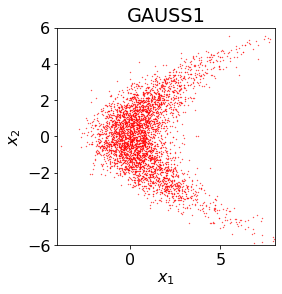

In [173]:
plt.scatter(X[:, 0], X[:, 1], s=0.1, color='red',label='Train')
#plt.scatter(X_test[:, 0], X_test[:, 1], s=1, color='blue',label='Test')
plt.title(TARGET_DENSITY)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect('equal')
##plt.legend()

In [174]:
class BatchNorm(tfb.Bijector):
    def __init__(self, eps=1e-5, decay=0.95, validate_args=False, name="batch_norm"):
        super(BatchNorm, self).__init__(
            event_ndims=1, validate_args=validate_args, name=name)
        self._vars_created = False
        self.eps = eps
        self.decay = decay

    def _create_vars(self, x):
        n = x.get_shape().as_list()[1]
        with tf.variable_scope(self.name):
            self.beta = tf.get_variable('beta', [1, n], dtype=DTYPE)
            self.gamma = tf.get_variable('gamma', [1, n], dtype=DTYPE)
            self.train_m = tf.get_variable(
                'mean', [1, n], dtype=DTYPE, trainable=False)
            self.train_v = tf.get_variable(
                'var', [1, n], dtype=DTYPE, initializer=tf.ones_initializer, trainable=False)
        self._vars_created = True

    def _forward(self, u):
        if not self._vars_created:
            self._create_vars(u)
        return (u - self.beta) * tf.exp(-self.gamma) * tf.sqrt(self.train_v + self.eps) + self.train_m

    def _inverse(self, x):
        # Eq 22. Called during training of a normalizing flow.
        if not self._vars_created:
            self._create_vars(x)
        # statistics of current minibatch
        m, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        # update train statistics via exponential moving average
        update_train_m = tf.assign_sub(
            self.train_m, self.decay * (self.train_m - m))
        update_train_v = tf.assign_sub(
            self.train_v, self.decay * (self.train_v - v))
        # normalize using current minibatch statistics, followed by BN scale and shift
        with tf.control_dependencies([update_train_m, update_train_v]):
            return (x - m) * 1. / tf.sqrt(v + self.eps) * tf.exp(self.gamma) + self.beta

    def _inverse_log_det_jacobian(self, x):
        # at training time, the log_det_jacobian is computed from statistics of the
        # current minibatch.
        if not self._vars_created:
            self._create_vars(x)
        _, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        abs_log_det_J_inv = tf.reduce_sum(
            self.gamma - .5 * tf.log(v + self.eps))
        return abs_log_det_J_inv

In [175]:
num_bijectors = settings[TARGET_DENSITY]['num_bijectors']
bijectors = []

for i in range(num_bijectors):
    if MODEL == 'NVP':
        bijectors.append(tfp.bijectors.RealNVP(
            num_masked=1,
            shift_and_log_scale_fn=tfb.real_nvp_default_template(
                hidden_layers=[512,512]),
            name='NVP%d' %i
            ))
    elif MODEL == 'MADE':
      bijectors.append(
          tfb.MaskedAutoregressiveFlow(name ='MADE',
            shift_and_log_scale_fn=tfb.AutoregressiveNetwork(params=2, hidden_units=[512, 512], activation='relu'),
            ))          
    elif MODEL == 'MAF':
        bijectors.append(tfb.MaskedAutoregressiveFlow( name ='MAF%d' %i, 
            shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
                params=2, hidden_units=[128, 128], activation='relu')))
    elif MODEL == 'IAF':
        bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(name ='IAF%d' %i,
            shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
                params=2, hidden_units=[512, 512], activation='relu'))))
    if USE_BATCHNORM:
        # BatchNorm helps to stabilize deep normalizing flows, esp. Real-NVP
        #bijectors.append(BatchNorm(name='batch_norm%d' % i))
        bijectors.append(tfb.BatchNormalization(name='BN%d' % i))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [176]:
"""
# TensorFlow Forum https://discuss.tensorflow.org/t/simple-realnvp-raises-keras-error/12170/4

base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE),name='base dist')
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)

flow_bijector_IAF = tfb.Invert(tfb.MaskedAutoregressiveFlow(name ='MAF',
            shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
                params=2, hidden_units=[512, 512], activation='relu')))

flow_bijector_MAF=tfb.MaskedAutoregressiveFlow( name ='MAF', 
            shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
                params=2, hidden_units=[128, 128], activation='relu'))

flow_bijector_NVP=tfp.bijectors.RealNVP(
            num_masked=1,
            shift_and_log_scale_fn=tfb.real_nvp_default_template(
                hidden_layers=[512,512]),
            name='NVP'
            )

def test(aBij):
  name = aBij.name
  try:
    print(f">>>>>>>>> START {name} ")
    trans_dist = tfd.TransformedDistribution(
        distribution=base_dist,
        bijector=aBij)

    log_prob_ = trans_dist.log_prob(x_)
    print(f"{name}:", log_prob_)

    model = tfk.Model(x_, log_prob_)

    print(f"<<<<<<<<< END {name} ")
  except Exception as e:
      print("Exception: " + str(e))


for aBij in [flow_bijector_MAF, flow_bijector_IAF, flow_bijector_NVP]:
  test(aBij)


"""


'\n# TensorFlow Forum https://discuss.tensorflow.org/t/simple-realnvp-raises-keras-error/12170/4\n\nbase_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE),name=\'base dist\')\nx_ = tfkl.Input(shape=(2,), dtype=tf.float32)\n\nflow_bijector_IAF = tfb.Invert(tfb.MaskedAutoregressiveFlow(name =\'MAF\',\n            shift_and_log_scale_fn=tfb.AutoregressiveNetwork(\n                params=2, hidden_units=[512, 512], activation=\'relu\')))\n\nflow_bijector_MAF=tfb.MaskedAutoregressiveFlow( name =\'MAF\', \n            shift_and_log_scale_fn=tfb.AutoregressiveNetwork(\n                params=2, hidden_units=[128, 128], activation=\'relu\'))\n\nflow_bijector_NVP=tfp.bijectors.RealNVP(\n            num_masked=1,\n            shift_and_log_scale_fn=tfb.real_nvp_default_template(\n                hidden_layers=[512,512]),\n            name=\'NVP\'\n            )\n\ndef test(aBij):\n  name = aBij.name\n  try:\n    print(f">>>>>>>>> START {name} ")\n    trans_dist = tfd.TransformedDistribu

In [177]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE),name='base dist')
trans_dist = tfd.TransformedDistribution(
        distribution=base_dist,
        bijector=flow_bijector)


In [178]:
x_test = trans_dist.sample()
trans_dist.log_prob(x_test)

<tf.Tensor: shape=(), dtype=float32, numpy=-3.5726278>

In [179]:
trans_dist.bijector.forward(X)

<tf.Tensor: shape=(4020, 2), dtype=float32, numpy=
array([[ 0.275093  ,  0.07873406],
       [-1.8302635 ,  1.205184  ],
       [-1.0895054 , -1.5153297 ],
       ...,
       [ 0.00869683, -0.03730178],
       [ 0.36772862, -1.4631456 ],
       [ 0.9145967 , -2.1755404 ]], dtype=float32)>

In [180]:
- tf.reduce_mean(trans_dist.log_prob(X))

<tf.Tensor: shape=(), dtype=float32, numpy=5.490439>

In [181]:
trans_dist.bijector

<tfp.bijectors._Chain 'chain_of_MADE' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=? bijectors=[<tfp.bijectors.MaskedAutoregressiveFlow 'MADE' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>]>

In [182]:
# visualization
x = base_dist.sample(8000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(trans_dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)


In [183]:
def _plot(results, names, rows=1, legend=False):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows), sharex=True, sharey=True)
    i = 0
    X0 = results[0].numpy()
    idxs = [np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0),
          np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0),
          np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0),
          np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    ]
    colors=['red','green','blue','black']
    for r in range(rows):
        for c in range(cols):
            res = results[i].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            for k, idx in enumerate(idxs):
                p.scatter(res[idx,0],res[idx,1], s=10, color=colors[k])
            p.set_xlim(xlim)
            p.set_ylim(ylim)
            p.set_title(names[i])
#            p.set_xticks([])
#            p.set_yticks([])
            
            i += 1
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

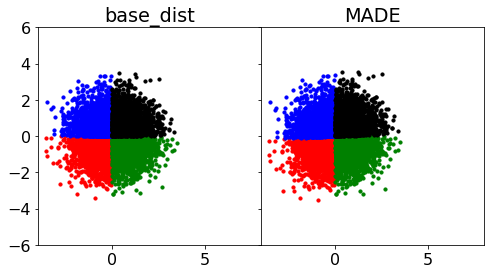

In [184]:
_plot(samples,names,1)

In [185]:
from tensorflow.keras.callbacks import LambdaCallback

In [186]:
def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x_ = tfkl.Input(shape=(2,), dtype=DTYPE)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
                  loss=lambda _, log_prob: -log_prob)

    ns = n_samples
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )


    history = model.fit(x=X,
                        y=np.zeros((ns, 0), dtype=np.float32),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback])
    return history

In [187]:
history= train_dist_routine(trans_dist, 
                   n_epochs=int(settings[TARGET_DENSITY]['n_epochs']), 
                   batch_size=int(settings[TARGET_DENSITY]['batch_size']),
                   n_disp=100)


 Epoch 1/500 
	 loss: 4.9194, val_loss: 4.5939

 Epoch 101/500 
	 loss: 4.1058, val_loss: 3.9909

 Epoch 201/500 
	 loss: 3.9152, val_loss: 3.8301

 Epoch 301/500 
	 loss: 3.8685, val_loss: 3.7950

 Epoch 401/500 
	 loss: 3.8592, val_loss: 3.7918


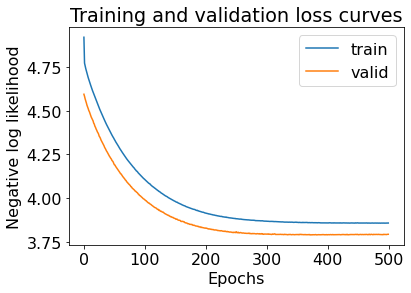

In [188]:
train_losses = history.history['loss']
val_losses = history.history['val_loss']
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='valid')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Negative log likelihood')
plt.title('Training and validation loss curves')
plt.show()

In [189]:
x = base_dist.sample(8000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(trans_dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

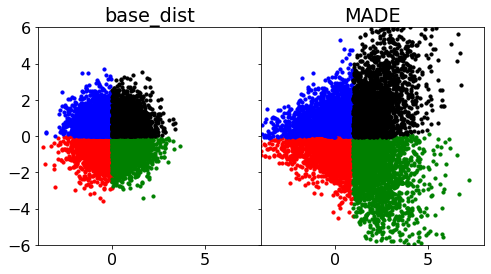

In [190]:
_plot(samples,names,1)

In [191]:
def visualize_training_data(orig, samples):
    f, arr = plt.subplots(1, 2, figsize=(15, 6))
    names = ['Data', 'Trained']
    samples = [orig, samples[-1].numpy()]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0], res[..., 1]
        arr[i].scatter(X, Y, s=0.1, color='red')
        arr[i].set_xlim(xlim)
        arr[i].set_ylim(ylim)
        arr[i].set_title(names[i])


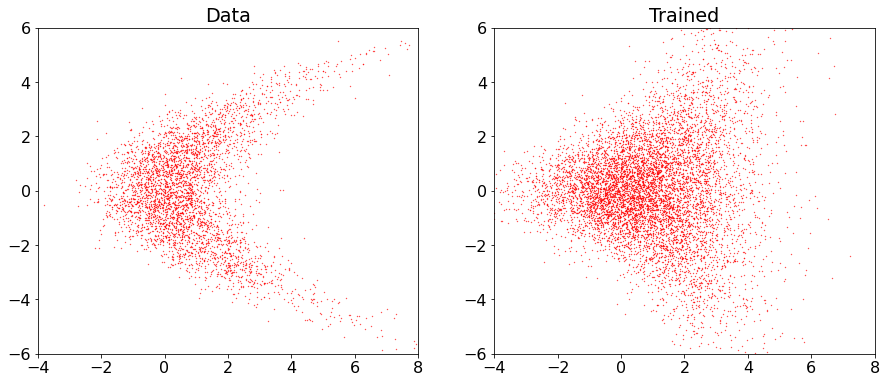

In [192]:
visualize_training_data(X,samples)

In [193]:
def plot_contour_prob(dist, rows=1, title=[''], scale_fig=4):
    cols = int(len(dist) / rows)
    xx = np.linspace(xlim[0],xlim[1], 100)
    yy = np.linspace(ylim[0],ylim[1], 100)
    X, Y = np.meshgrid(xx, yy)

    fig, ax = plt.subplots(rows, cols, figsize=(scale_fig * cols, scale_fig * rows))
    fig.tight_layout(pad=4.5)

    i = 0
    for r in range(rows):
        for c in range(cols):
            Z = dist[i].prob(np.dstack((X, Y)))
            if len(dist) == 1:
                axi = ax
            elif rows == 1:
                axi = ax[c]
            else:
                axi = ax[r, c]

            # Plot contour
            p = axi.contourf(X, Y, Z)

            # Add a colorbar
            divider = make_axes_locatable(axi)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            cbar = fig.colorbar(p, cax=cax)

            # Set title and labels
            axi.set_title(str(title[i]))
            axi.set_xlabel('x')
            axi.set_ylabel('y')

            i += 1
    plt.show()

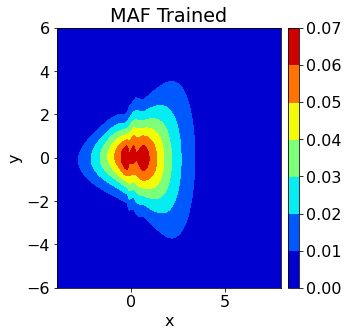

In [194]:
plot_contour_prob([trans_dist],title=["MAF Trained"],scale_fig=6)

In [195]:
x = tf.convert_to_tensor(X_test)
c_samples = [x]
c_names = [""]
for bijector in trans_dist.bijector.bijectors:
    x = bijector.inverse(x)
    c_samples.append(x)
    c_names.append(bijector.name)

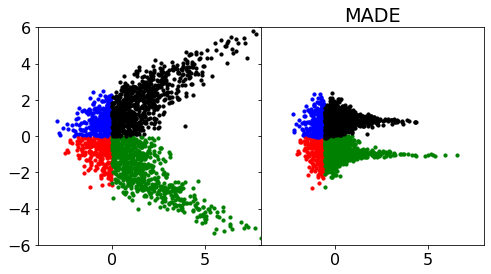

In [196]:
_plot(c_samples,c_names,1)

In [151]:
!pip install pingouin 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [152]:
import pingouin as pg

In [157]:
# test normality of Inverse transformed X_test samples
print(pg.multivariate_normality(c_samples[-1])) # Multivariate normality


HZResults(hz=1.0253568626582719, pval=0.13524668182031774, normal=True)


In [158]:
# as a comparison here is True Normal samples result
normal_spl = base_dist.sample(2000)
print(pg.multivariate_normality(normal_spl))

HZResults(hz=0.7702528028384614, pval=0.5296151012840621, normal=True)
